In [8]:
%reload_ext autoreload
%autoreload 
%matplotlib inline

In [9]:
from fastai import *
from fastai.vision import *
import scipy.io 
import numpy as np
import os
from tqdm import tqdm

In [10]:
path = Path('.')
path.ls()

[PosixPath('test-set2-256'),
 PosixPath('train'),
 PosixPath('submission.csv'),
 PosixPath('df_test_id_set1.csv'),
 PosixPath('test.csv'),
 PosixPath('google-landmark'),
 PosixPath('train-256.tar'),
 PosixPath('Data cleaning - find missing files and download.ipynb'),
 PosixPath('export_dataframe.csv'),
 PosixPath('df_test_prob_set1.csv'),
 PosixPath('df_test_id.csv'),
 PosixPath('test-256.zip'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('train-448'),
 PosixPath('Kaggle_google_landmark_recognition.ipynb'),
 PosixPath('export.pkl'),
 PosixPath('test-set1'),
 PosixPath('download and resized image.ipynb'),
 PosixPath('df_test_label.csv'),
 PosixPath('idlist.csv'),
 PosixPath('models'),
 PosixPath('df_test_prob.csv'),
 PosixPath('imglist.csv'),
 PosixPath('df_test_label_set1.csv'),
 PosixPath('google-landmark-1'),
 PosixPath('validation_random.csv'),
 PosixPath('train.csv'),
 PosixPath('Untitled.ipynb'),
 PosixPath('README.md')]

## View the data

In [4]:
df=pd.read_csv(path/'train.csv')

In [15]:
df=df.drop('url',axis=1)
df.head()

,id,landmark_id
0,6e158a47eb2ca3f6,142820
1,202cd79556f30760,104169
2,3ad87684c99c06e1,37914
3,e7f70e9c61e66af3,102140
4,4072182eddd0100e,2474


## Data training

In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [5]:
src = (ImageList.from_csv(path,'validation_random.csv', folder='train', suffix='.jpg'
                                  ).split_from_df(col='is_valid')
                                   .label_from_df(cols='landmark_id'))

In [6]:
data=(src.transform(tfms,size=256).databunch().normalize(imagenet_stats))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

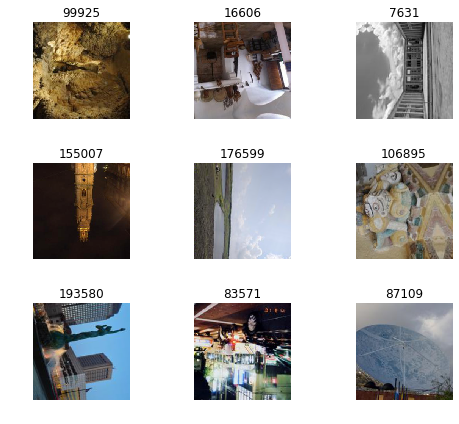

In [33]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
learn = cnn_learner(data, models.resnet34, ps=0.2, metrics=accuracy)

In [9]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,13.511383,11.518536,0.036535,6:23:58


In [10]:
learn.save('stage-1.2-res34-frac0.2-ps0.2-accuracy')

In [ ]:
learn.fit_one_cycle(1)
learn.save('stage-1.2-ep2-res34-frac0.2-ps0.2-accuracy')

epoch,train_loss,valid_loss,accuracy,time


In [4]:
# learn.load('stage-1.2-res34-frac0.2-ps0.2-accuracy')

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


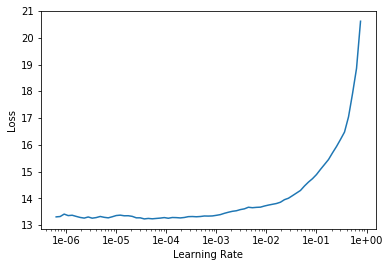

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1,max_lr=slice(0.5e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,12.803339,11.003296,0.054681,8:17:37


In [13]:
learn.save('stage-2-ep1-res34-frac0.2-ps0.2-accuracy')

In [14]:
learn.fit_one_cycle(1,max_lr=slice(0.5e-4,1e-3))
learn.save('stage-2-ep2-res34-frac0.2-ps0.2-accuracy')

epoch,train_loss,valid_loss,accuracy,time
0,12.613505,10.746296,0.070127,8:17:00


In [5]:
# learn.fit_one_cycle(1,max_lr=slice(0.5e-4,1e-3))
# learn.save('stage-2-ep3-res34-frac0.2-ps0.2-accuracy')

In [16]:
learn.save('stage-2-ep3-res34-frac0.2-ps0.2-accuracy')

In [6]:
# learn.load('stage-2-ep3-res34-frac0.2-ps0.2-accuracy')

In [13]:
learn.export()

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

## Inference

In [4]:
listtest=[]
listtest=get_image_files('./test-set2-256/')

listtest1=listtest[:20000]
listtest2=listtest[20000:40000]
listtest3=listtest[40000:60000]
listtest4=listtest[60000:80000]
listtest5=listtest[80000:100000]
listtest6=listtest[100000:]
len(listtest1)+len(listtest2)+len(listtest3)+len(listtest4)+len(listtest5)+len(listtest6)

117577

In [5]:
dftest1=pd.DataFrame(listtest1)
dftest2=pd.DataFrame(listtest2)
dftest3=pd.DataFrame(listtest3)

In [6]:
learn = load_learner(path='.', test=ImageList.from_folder('./test-set2-256/'))

In [7]:
# def inference(f):
pred_class=[]
pred_label=[]
pred_prob=[]
pred_id=[]
for i in tqdm(listtest6):
#     img=open_image(get_image_files('./test/'+f))
    img=open_image(i)
    c,l,p=learn.predict(img)
    pred_id.append(str(i.name).split('.')[0])
    pred_class.append(c)
    pred_label.append(l)
    pred_prob.append(p)
#     break
# print(c,l,p)
#     return c,l,p[0]

100%|██████████| 17577/17577 [09:38<00:00, 30.40it/s]


In [8]:
#calculate max prob
listlabel=[]
listprob=[]
for i in tqdm(range(len(pred_label))):
    listlabel.append(pred_label[i].numpy())
    listprob.append(max(pred_prob[i].numpy()))

100%|██████████| 17577/17577 [05:31<00:00, 53.00it/s]


In [11]:
#load csv
import csv 

with open('df_test_label.csv','r') as f:
    reader = csv.reader(f)
    listlabel_prev=list(reader)
with open('df_test_prob.csv','r') as f:
    reader = csv.reader(f)
    listprob_prev=list(reader)
with open('df_test_id.csv','r') as f:
    reader = csv.reader(f)
    listid_prev=list(reader)

In [10]:
#save pred_y to csv
df_test_id_1=pd.DataFrame(listid_prev)
df_test_label_1=pd.DataFrame(listlabel_prev)
df_test_prob_1=pd.DataFrame(listprob_prev)

df_test_id_2=pd.DataFrame(pred_id)
df_test_label_2=pd.DataFrame(listlabel)
df_test_prob_2=pd.DataFrame(listprob)

df_test_id_tot=pd.concat([df_test_id_1,df_test_id_2],ignore_index=True)
df_test_label_tot=pd.concat([df_test_label_1,df_test_label_2],ignore_index=True)
df_test_prob_tot=pd.concat([df_test_prob_1,df_test_prob_2],ignore_index=True)

print(df_test_id_tot.tail(),df_test_label_tot.tail(),df_test_prob_tot.tail())
df_test_id_tot.to_csv('df_test_id.csv',index=False, header=False)
df_test_label_tot.to_csv('df_test_label.csv',index=False, header=False)
df_test_prob_tot.to_csv('df_test_prob.csv',index=False, header=False)

                       0
117572  34c9d9dd90fc7bdd
117573  8488bd0c53c5b681
117574  eef08b7e0e2a973c
117575  51c6e1cc704d9b03
117576  0aa3a0b084189510              0
117572   83653
117573   80177
117574  102206
117575  176528
117576  120885                 0
117572  0.0462588
117573  0.0216332
117574  0.0384973
117575   0.104459
117576  0.0249421


In [21]:
# examine predicted labels distribution
df=pd.DataFrame(listprob_prev,columns=['prob']).astype(float)
df.describe()

,prob
count,117577.000000
mean,0.093597
std,0.107911
min,0.003987
25%,0.031579
50%,0.056319
75%,0.109991
max,0.999449


In [13]:
preds,y=learn.get_preds(ds_type=DatasetType.Test)

In [28]:
type(float(listprob_prev[1][0]))

float

## Submission file

In [29]:
list_label_prob=[]
for i in tqdm(range(len(listlabel_prev))):
    if float(listprob_prev[i][0])>= 0.031579:
        list_label_prob.append(str(listlabel_prev[i][0])+' '+str(listprob_prev[i][0]))
    else:
        list_label_prob.append(None)
    
print(list_label_prob[:5])

100%|██████████| 117577/117577 [00:00<00:00, 759561.53it/s]

['168098 0.03859742730855942', '30356 0.03921181708574295', None, '177870 0.05002662166953087', None]


In [30]:
dfid_sub=pd.DataFrame(listid_prev,columns=['id'])
dflab_sub=pd.DataFrame(list_label_prob,columns=['landmarks'])
print(len(dfid_sub),len(dflab_sub),dfid_sub.tail(),dflab_sub.tail())
df_sub=pd.concat([dfid_sub,dflab_sub],axis=1)
df_sub.tail()

117577 117577                       id
117572  34c9d9dd90fc7bdd
117573  8488bd0c53c5b681
117574  eef08b7e0e2a973c
117575  51c6e1cc704d9b03
117576  0aa3a0b084189510                          landmarks
117572   83653 0.04625881463289261
117573                        None
117574  102206 0.03849728778004646
117575  176528 0.10445878654718399
117576                        None


,id,landmarks
117572,34c9d9dd90fc7bdd,83653 0.04625881463289261
117573,8488bd0c53c5b681,None
117574,eef08b7e0e2a973c,102206 0.03849728778004646
117575,51c6e1cc704d9b03,176528 0.10445878654718399
117576,0aa3a0b084189510,None


In [31]:
df_sub.to_csv('submission.csv',index=False)